# 實作 CycleGAN 演算法
### 程式修改自[CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan)

In [3]:
# 載入相關套件
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 類似 prefetch()，可以提升資料集存取效能
AUTOTUNE = tf.data.AUTOTUNE

## 載入訓練資料

In [4]:
# 載入訓練資料
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

## 定義圖像處理的函數

In [5]:
# 參數設定
BUFFER_SIZE = 1000 # 緩衝區大小
BATCH_SIZE = 1     # 批量
IMG_WIDTH = 256    # 圖像寬度
IMG_HEIGHT = 256   # 圖像高度

# 隨機裁切圖像
def random_crop(image):
    cropped_image = tf.image.random_crop(
            image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# 標準化，使像素值介於 [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

# 隨機轉換
def random_jitter(image):
    # 縮放圖像為 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 隨機裁切至 256 x 256 x 3
    image = random_crop(image)

    # 水平翻轉
    image = tf.image.random_flip_left_right(image)
    return image

## 定義資料前置處理的函數，設定資料集屬性

In [6]:
# 訓練資料前置處理
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

# 測試資料前置處理
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

# 設定資料集屬性
train_horses = train_horses.map(
        preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
        preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
        preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
        preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(1)

## 資料測試

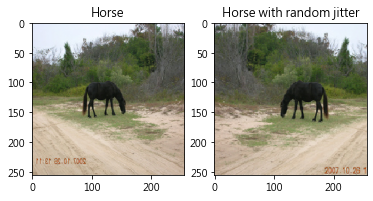

In [7]:
# 各取一筆資料測試
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

plt.subplot(121)
plt.title('Horse')
# 轉換為 [0, 1]
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
# 將像素值由 [-1, 1] 轉換為 [0, 1]，才能顯示
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

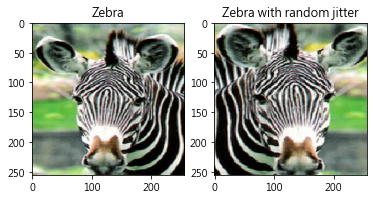

In [8]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## 定義 CycleGAN 神經網路

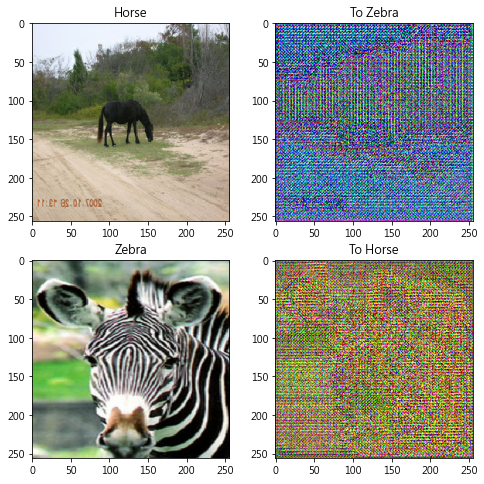

In [9]:
# 定義生成神經網路
OUTPUT_CHANNELS = 3

# 以 Pix2Pix 的模型建立 CycleGAN 
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

# 生成圖像
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

# 顯示圖片
imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## 判別網路圖像測試

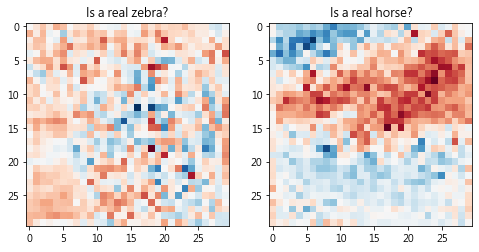

In [10]:
# 判別網路圖像測試
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
# 使用判別網路辨識圖像
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
# 使用判別網路辨識圖像
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 定義損失函數

In [13]:
# 定義損失函數為二分類交叉熵
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 定義判別網路損失函數
def discriminator_loss(real, generated):
    # 真實資料的損失
    real_loss = loss_obj(tf.ones_like(real), real)

    # 生成資料的損失
    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    # 總損失
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

# 定義生成網路損失函數
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# 定義循環損失函數，參見圖 10.21 CycleGAN 網路結構
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

# 定義 Identity 損失函數， |G(Y)-Y| + |f(X)-X|
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## 定義優化器

In [15]:
# 定義優化器
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 定義檢查點

In [16]:
# 定義檢查點
checkpoint_path = "./CycleGAN_checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果檢查點存在，回復至最後一個檢查點
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## 定義生成圖像及顯示的函數

In [17]:
# 定義生成圖像及顯示的函數
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## 定義訓練模型的函數

In [18]:
# 參數設定
EPOCHS = 40

# 定義訓練模型的函數
@tf.function
def train_step(real_x, real_y):
    # persistent=True：表示 tf.GradientTape 會重複使用
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # 計算生成網路損失
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # 計算循環損失
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # 計算總損失 Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # 計算生成網路梯度
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                          generator_f.trainable_variables)

    # 計算判別網路梯度
    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                              discriminator_y.trainable_variables)

    # 更新權重
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                  discriminator_y.trainable_variables))

## 訓練模型

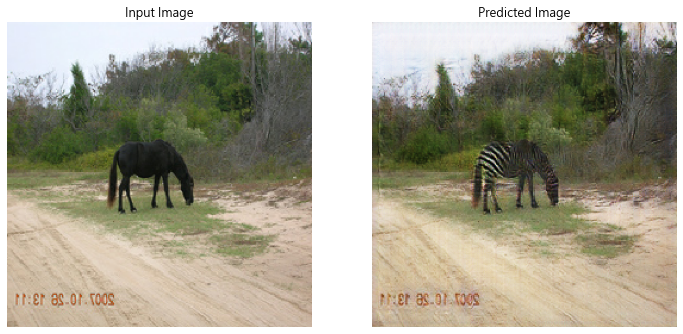

Saving checkpoint for epoch 40 at ./CycleGAN_checkpoints/train\ckpt-8
Time taken for epoch 40 is 1233.0059795379639 sec



In [19]:
# 訓練模型
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # 產生圖像
    generate_images(generator_g, sample_horse)

    # 檢查點存檔
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    # 計時
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

## 取 5 筆資料測試

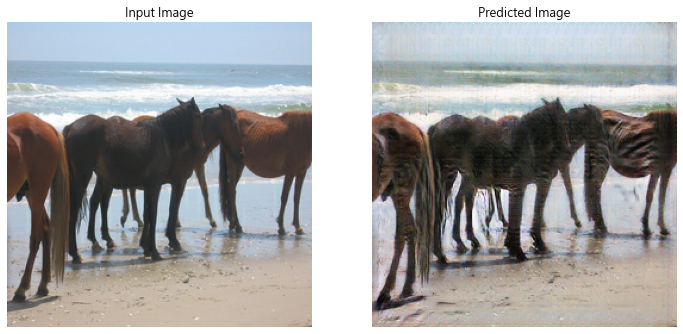

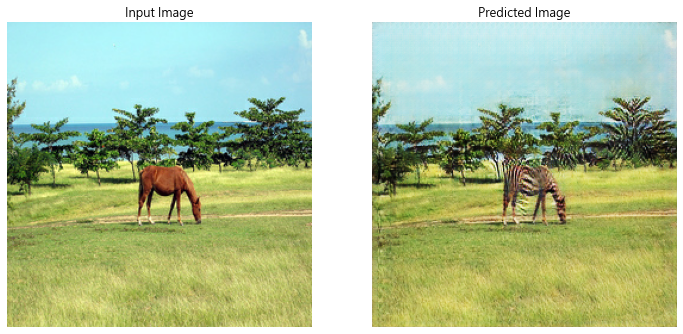

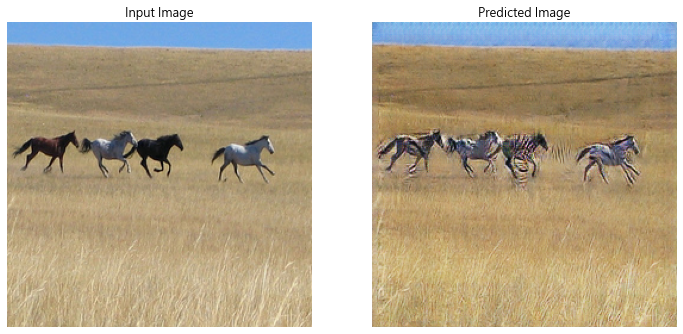

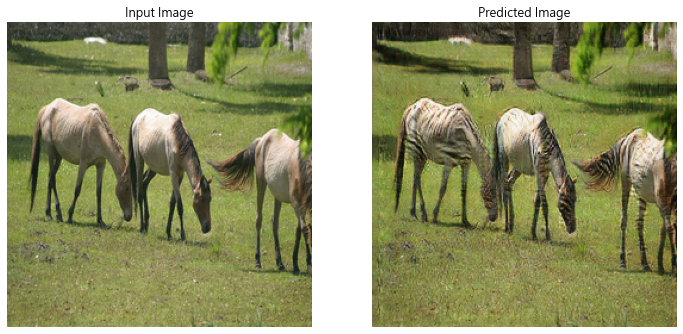

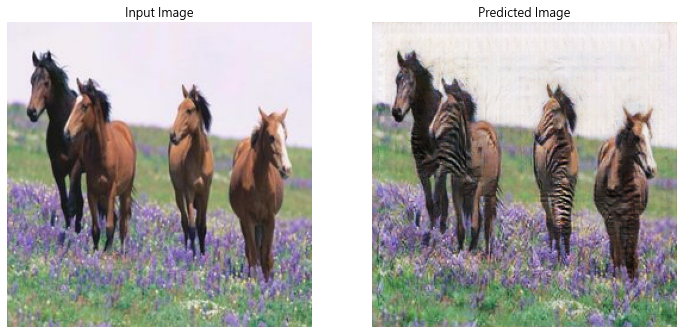

In [21]:
# 取 5 筆資料測試
for inp in test_horses.take(5):
    generate_images(generator_g, inp)